In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

DEFAULT_FIG_SIZE = 5

def plot_images(imgs, rows, cols, figsize=DEFAULT_FIG_SIZE):
  if imgs.shape[0] != rows * cols:
    raise Error('Broj slika razlicit od velicine tabele')
  f, axs = plt.subplots(rows, cols)
  f.set_figheight(figsize)
  f.set_figwidth(figsize)
  plt.gray()
  for i, img in enumerate(prepare_for_plotting(imgs)):
    x = i % cols
    y = i // cols
    axs[y, x].imshow(img)
    axs[y, x].axis('off')
  plt.show()

def prepare_data(imgs):
  if imgs.ndim == 3:
    imgs = imgs.reshape((*imgs.shape, 1))
  imgs = imgs.astype('float32') / 255.
  return imgs

def prepare_for_plotting(imgs):
  if imgs.ndim == 4 and imgs.shape[3] == 1:
    imgs = imgs.reshape(imgs.shape[:3])
  return imgs

def download_and_prepare_data(dataset):
  (x_train, y_train), (x_test, y_test) = dataset.load_data()
  x_train = prepare_data(x_train)
  x_test = prepare_data(x_test)
  return (x_train, y_train), (x_test, y_test)

def eval_model(reconstruction_model, classification_model, eval_data):
  if len(eval_data) != 2:
    raise Error(
        'Evaluacioni podaci moraju imati ulaz i labele, ovo nema odgovarajuce dimenzije!')
  x_eval, y_eval = eval_data
  print('|====| Evaluacija rekonstruktivnog modela |=====|')

  estimation_model = keras.Sequential([reconstruction_model, classification_model])
  estimation_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  est_loss, est_acc = estimation_model.evaluate(x_eval, y_eval, verbose=0)
  print(f'  Loss pri klasifikaciji rekonstruisanih slika: {est_loss}\n  Preciznost pri klasifikaciji rekonstruisanih slika: {est_acc}')
  
  print('  -------------------')

  accuracy = keras.metrics.Accuracy()
  accuracy.reset_states()
  data_set = tf.data.Dataset.from_tensor_slices((x_test, x_test)).shuffle(1024). batch(32)
  for x, _ in data_set:
    predicted_classes = classification_model(x).numpy().argmax(1)
    reconstructed_prediction = estimation_model(x).numpy().argmax(1)
    accuracy.update_state(predicted_classes, reconstructed_prediction)
  print(f'  Identicnost klasifikacije: {accuracy.result().numpy()}')

  print('  -------------------')
  
  eval_res = reconstruction_model.evaluate(x_eval, x_eval, verbose=0)
  print(f'  Loss modela za rekonstrukciju: {eval_res[0] if type(eval_res) is list else eval_res}')

  print('  -------------------')

  classification_loss, classification_acc = classification_model.evaluate(x_eval, y_eval, verbose=0)
  print(f'  Loss klasifikatora: {classification_loss}\n  Accuracy klasifikatora: {classification_acc}')

  print('|===============================================|')

def create_and_train_reconstruction_model(
    classification_body, 
    classification_model, 
    reconstruction_head,
    x_train,
    epochs):
  reconstruction_model = keras.Sequential([
    classification_body,
    reconstruction_head
  ])
  optimizer = keras.optimizers.Adam(1e-3)
  reconstruction_model.compile(
    loss='mse',
    metrics=['mse']
  )
  mse = keras.metrics.MeanSquaredError()
  reconstruction_training_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train)).shuffle(1024).batch(32)

  reconstruction_forward_check_model = keras.Sequential([
    reconstruction_model, 
    classification_body
  ])

  reconstruction_full_foward_check_model = keras.Sequential([
    reconstruction_model, 
    classification_model
  ])

  for epoch in range(epochs):
    mse.reset_states()
    print(f'Epochs {epoch}')
    iter = 0
    for x, y in reconstruction_training_dataset:
      with tf.GradientTape() as tape:
        prediction = reconstruction_model(x)
        #original_mid_value = classification_body(x)
        #reconstructed_mid_value = reconstruction_forward_check_model(x)
        original_logits = classification_model(x)
        reconstructed_logits = reconstruction_full_foward_check_model(x)
        #loss = keras.losses.mean_squared_error(y, prediction)
        #loss = keras.backend.mean(keras.losses.mean_squared_error(y, prediction)) + keras.backend.mean(keras.losses.mean_squared_error(original_mid_value, reconstructed_mid_value))
        #loss = keras.backend.sum(keras.losses.mean_squared_error(y, prediction)) + keras.backend.sum(keras.losses.mean_squared_error(original_mid_value, reconstructed_mid_value))
        #loss = keras.losses.mean_squared_error(original_mid_value, reconstructed_mid_value)
        #loss = keras.backend.mean(keras.losses.mean_squared_error(y, prediction)) + keras.backend.mean(keras.losses.categorical_crossentropy(original_logits, reconstructed_logits))
        #loss = keras.backend.sum(keras.losses.mean_squared_error(y, prediction)) + keras.backend.sum(keras.losses.categorical_crossentropy(original_logits, reconstructed_logits))
        loss = keras.losses.categorical_crossentropy(original_logits, reconstructed_logits)
      mse.update_state(y, prediction)
      gradients = tape.gradient(loss, reconstruction_head.trainable_variables)
      optimizer.apply_gradients(zip(gradients, reconstruction_head.trainable_variables))
      if iter % 500 == 0:
        print(f'  iter{iter} MSE: {mse.result().numpy()}')
      iter += 1
    l, a = classification_model.evaluate(x_test, y_test, verbose=0)
    print(f'Loss: {l}\nAcc: {a}')
  return reconstruction_model

In [ ]:
(x_train, y_train), (x_test, y_test) = download_and_prepare_data(keras.datasets.mnist)
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
PREFIX = 'drive/My Drive/KFN/mnistConv'

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
classification_body = keras.Sequential([
  keras.layers.Conv2D(32, 2, padding='same', activation=tf.nn.relu, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),
  keras.layers.Conv2D(32, 2, padding='same', activation=tf.nn.relu),
  keras.layers.MaxPool2D(2),
  keras.layers.Conv2D(64, 2, padding='same', activation=tf.nn.relu),
  keras.layers.Conv2D(128, 2, padding='same', activation=tf.nn.relu),
  keras.layers.MaxPool2D(2),
  keras.layers.Flatten(),
  keras.layers.Dense(20, activation=tf.nn.relu)
])

classification_head = keras.Sequential([
  keras.layers.Dense(10, activation=tf.nn.softmax)
])

classification_model = keras.Sequential([
  classification_body,
  classification_head
])

classification_model.compile(
  optimizer=keras.optimizers.Adam(1e-3),
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=[
    keras.metrics.SparseCategoricalAccuracy('preciznost')
  ]
)

classification_model.fit(x_train, y_train, epochs=2)
classification_model.evaluate(x_test, y_test)

Epoch 1/2
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1705 - preciznost: 0.9474
Epoch 2/2
313/313 [==============================] - 1s 4ms/step - loss: 0.0447 - preciznost: 0.9847


[0.04469042271375656, 0.9847000241279602]

In [ ]:
autoencoder = keras.Sequential([
  keras.layers.Conv2D(32, 2, padding='same', activation=tf.nn.relu, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),
  keras.layers.Conv2D(32, 2, padding='same', activation=tf.nn.relu),
  keras.layers.MaxPool2D(2),
  keras.layers.Conv2D(64, 2, padding='same', activation=tf.nn.relu),
  keras.layers.Conv2D(128, 2, padding='same', activation=tf.nn.relu),
  keras.layers.MaxPool2D(2),
  keras.layers.Flatten(),
  keras.layers.Dense(20, activation=tf.nn.relu, name='Bottleneck'),
  keras.layers.Dense(7 * 7 * 128, activation=tf.nn.tanh),
  keras.layers.Reshape((7, 7, 128)),
  #keras.layers.Conv2DTranspose(128, 2, strides=1, activation=tf.nn.tanh, padding='same'),
  keras.layers.Conv2DTranspose(64, 2, strides=2, activation=tf.nn.tanh),
  keras.layers.Conv2DTranspose(32, 2, strides=2, activation=tf.nn.tanh),
  keras.layers.Conv2D(1, 1, activation=tf.nn.tanh)
])

autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])
autoencoder.build()

#autoencoder.fit(x_train, x_train, epochs=4)
#autoencoder.evaluate(x_test, x_test)

In [ ]:
reconstruction_head = keras.Sequential([
  keras.layers.Dense(7 * 7 * 128, activation=tf.nn.tanh),
  keras.layers.Reshape((7, 7, 128)),
  #keras.layers.Conv2DTranspose(128, 2, strides=1, activation=tf.nn.tanh, padding='same'),
  keras.layers.Conv2DTranspose(64, 2, strides=2, activation=tf.nn.tanh),
  keras.layers.Conv2DTranspose(32, 2, strides=2, activation=tf.nn.tanh),
  keras.layers.Conv2D(1, 1, activation=tf.nn.tanh)
])

reconstruction_model = create_and_train_reconstruction_model(
    classification_body, 
    classification_model, 
    reconstruction_head, 
    x_train, 
    5)

Epochs 0
  iter0 MSE: 0.14586107432842255
  iter500 MSE: 0.37216535210609436
  iter1000 MSE: 0.4078824520111084
  iter1500 MSE: 0.4304395318031311
Loss: 0.04069562256336212
Acc: 0.9876000285148621
Epochs 1
  iter0 MSE: 0.4814905524253845
  iter500 MSE: 0.5052908658981323
  iter1000 MSE: 0.5157771110534668
  iter1500 MSE: 0.5179436206817627
Loss: 0.04069562256336212
Acc: 0.9876000285148621
Epochs 2
  iter0 MSE: 0.5162831544876099
  iter500 MSE: 0.5047747492790222
  iter1000 MSE: 0.49330079555511475
  iter1500 MSE: 0.48428604006767273
Loss: 0.04069562256336212
Acc: 0.9876000285148621
Epochs 3
  iter0 MSE: 0.47150811553001404
  iter500 MSE: 0.4544682204723358
  iter1000 MSE: 0.4407944977283478
  iter1500 MSE: 0.4359389543533325
Loss: 0.04069562256336212
Acc: 0.9876000285148621
Epochs 4
  iter0 MSE: 0.4048888683319092
  iter500 MSE: 0.4236084222793579
  iter1000 MSE: 0.42475661635398865
  iter1500 MSE: 0.42391297221183777
Loss: 0.04069562256336212
Acc: 0.9876000285148621


Original:


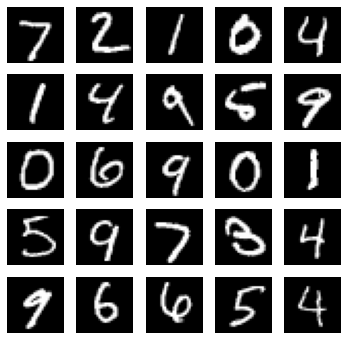

Autoencoder:


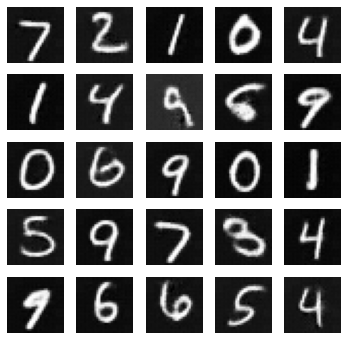

KFN MSE:


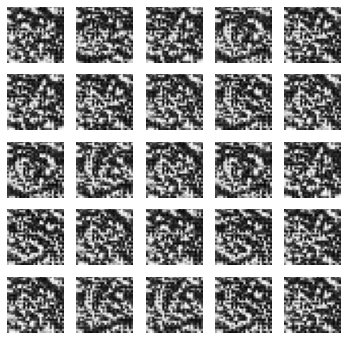

In [ ]:
ROWS = 5
COLS = 5
FIGSIZE = 6

print('Original:')
plot_images(x_test[:ROWS * COLS], ROWS, COLS, FIGSIZE)
print('Autoencoder:')
plot_images(autoencoder(x_test[:ROWS * COLS]).numpy(), ROWS, COLS, FIGSIZE)
print('KFN:')
plot_images(reconstruction_model(x_test[:ROWS * COLS]).numpy(), ROWS, COLS, FIGSIZE)

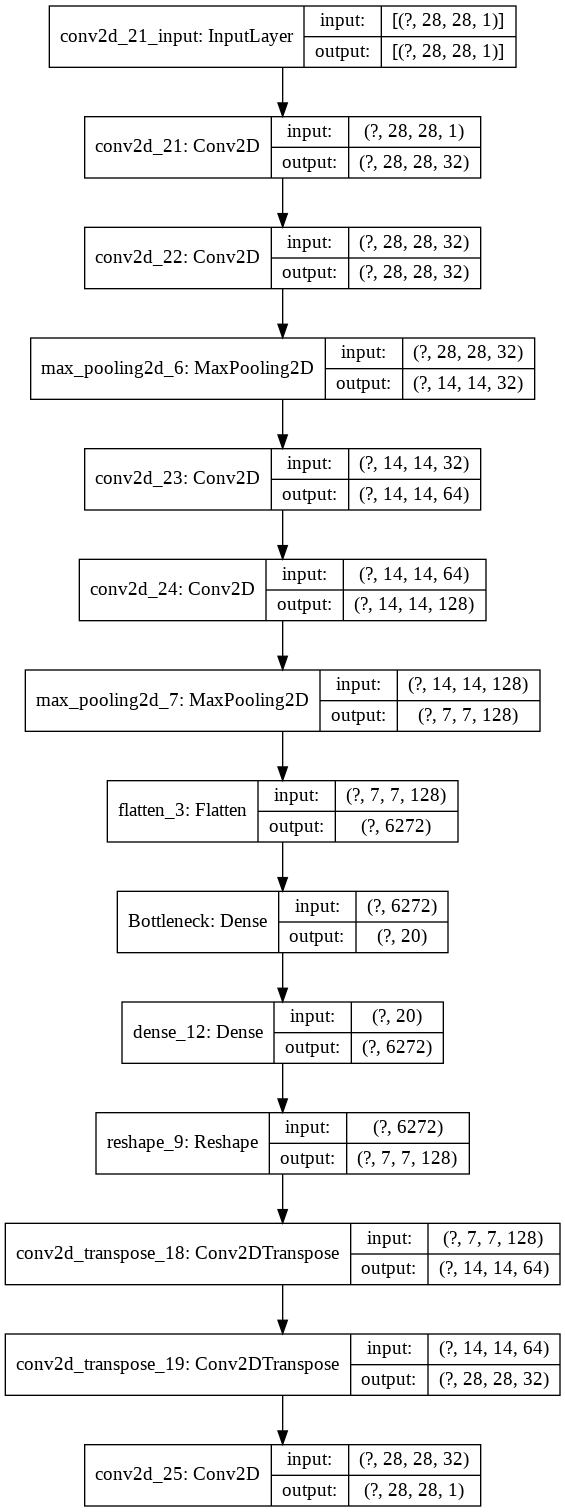

In [ ]:
keras.utils.plot_model(autoencoder, show_shapes=True)

In [ ]:
eval_model(autoencoder, classification_model, (x_test, y_test))
eval_model(reconstruction_model, classification_model, (x_test, y_test))

|====| Evaluacija rekonstruktivnog modela |=====|
  Loss pri klasifikaciji rekonstruisanih slika: 0.14436349272727966
  Preciznost pri klasifikaciji rekonstruisanih slika: 0.9560999870300293
  -------------------
  Identicnost klasifikacije: 0.9638000130653381
  -------------------
  Loss modela za rekonstrukciju: 0.011061353608965874
  -------------------
  Loss klasifikatora: 0.051430705934762955
  Accuracy klasifikatora: 0.9840999841690063
|===============================================|
|====| Evaluacija rekonstruktivnog modela |=====|
  Loss pri klasifikaciji rekonstruisanih slika: 0.05731543153524399
  Preciznost pri klasifikaciji rekonstruisanih slika: 0.982699990272522
  -------------------
  Identicnost klasifikacije: 0.9969000220298767
  -------------------
  Loss modela za rekonstrukciju: 0.38180792331695557
  -------------------
  Loss klasifikatora: 0.051430705934762955
  Accuracy klasifikatora: 0.9840999841690063
|===============================================|
